# 2. Relation between NP class and Taxon

## 2.1 Taxon information extract from LOTUS 

In [1]:
#! mongod should be started firstly

import pandas as pd
import pymongo
from pymongo.mongo_client import MongoClient

conn = MongoClient('localhost', port=27017)
db = conn['lotus']
col = db['lotusUniqueNaturalProduct']

In [2]:
## settings
# tx_level = 'phylum' # 门


def exTaxon(data, tx_level = 'kingdom'):
    results = []
    i = 0
    for it in data:
        taxon = it['taxonomyReferenceObjects']
        tx_names = set()
        for key_1 in taxon:
            for key_2 in taxon[key_1]:
                for entry in taxon[key_1][key_2]:
                    if tx_level in entry:
                        tx_names.add(entry[tx_level])
        if len(tx_names) > 0:
            for tx in tx_names:
                results.append({'lotus_id':it['lotus_id'], tx_level:tx})
        i += 1
        print('%d:: %s was extract'%(i, it['lotus_id']), end='\r', flush=True)

    return pd.DataFrame(results)

In [3]:
lotus = col.find({},{'_id':False, 'lotus_id':1, 'taxonomyReferenceObjects':1})

import sqlite3
inp = sqlite3.connect('../data/iNP.db')

# extracting kingdom
tx_level = 'kingdom'
kingdom = exTaxon(lotus, tx_level)
kingdom.to_sql(tx_level, inp, if_exists='replace', index=False)

662855

In [4]:
lotus = col.find({},{'_id':False, 'lotus_id':1, 'taxonomyReferenceObjects':1})
tx_level = 'family'
family = exTaxon(lotus, tx_level)
family.to_sql(tx_level, inp, if_exists='replace', index=False)

412662

In [5]:
lotus = col.find({},{'_id':False, 'lotus_id':1, 'taxonomyReferenceObjects':1})
tx_level = 'genus'
genus = exTaxon(lotus, tx_level)
genus.to_sql(tx_level, inp, if_exists='replace', index=False)

485998

In [6]:
conn.close()
inp.close()

## Ploting heatmap: kingdom and pathway relation

In [5]:
import sqlite3
import pandas as pd
inp = sqlite3.connect('../data/iNP.db')
kingdom = pd.read_sql('SELECT * FROM kingdom', inp)
lotus = pd.read_sql('SELECT lotus_id, pathway FROM lotusNP', inp)
inp.close()
kingdom.info()
lotus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662855 entries, 0 to 662854
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   lotus_id  662855 non-null  object
 1   kingdom   662855 non-null  object
dtypes: object(2)
memory usage: 10.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276518 entries, 0 to 276517
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   lotus_id  276518 non-null  object
 1   pathway   276518 non-null  object
dtypes: object(2)
memory usage: 4.2+ MB


In [6]:
kingdom = pd.merge(kingdom, lotus, how='left', on='lotus_id')
kingdom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662855 entries, 0 to 662854
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   lotus_id  662855 non-null  object
 1   kingdom   662855 non-null  object
 2   pathway   662855 non-null  object
dtypes: object(3)
memory usage: 15.2+ MB


In [7]:
data = kingdom.value_counts(subset=['pathway', 'kingdom']).reset_index()
data.loc[data['kingdom']=='', 'kingdom'] = 'Unknown' 
data['pathway'] = data['pathway'].str.replace(r'^\s*$', 'Other', regex=True)

data2 = data.pivot(index='pathway', columns='kingdom',values='count')
data2.fillna(0,inplace=True)
data2 = data2.astype(int)

data2.shape

(8, 11)

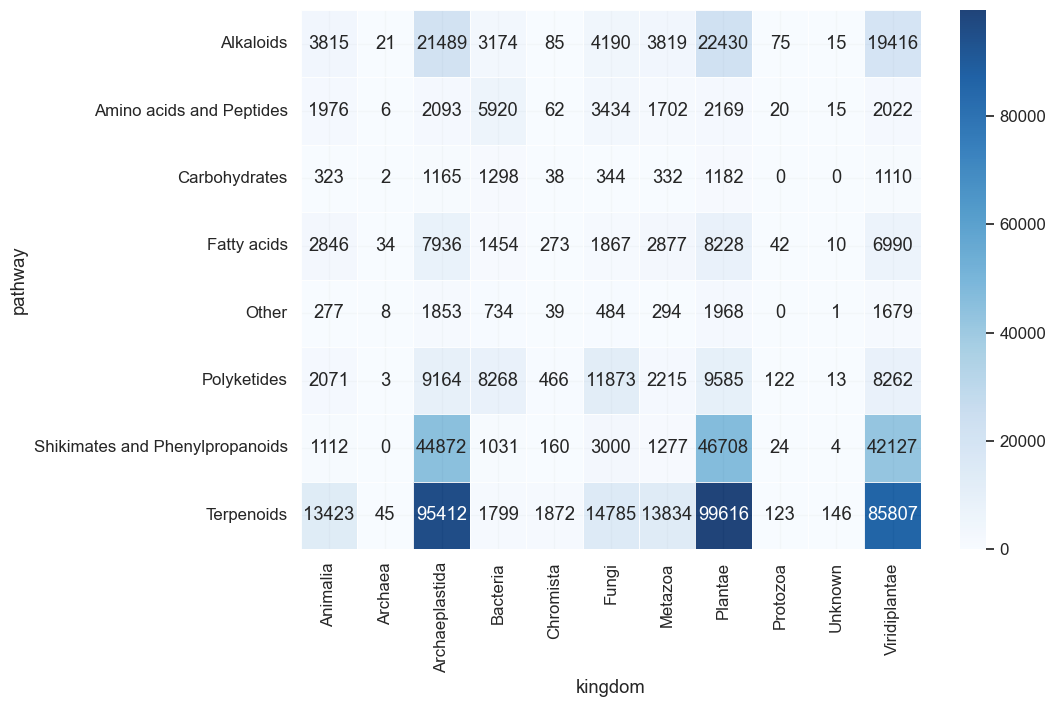

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.1)

f, ax = plt.subplots(figsize=(10, 7))
cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
fig = sns.heatmap(data2, annot=True, fmt="d", linewidths=.5, ax=ax, cmap='Blues', alpha=0.9)
fig.figure.savefig('../plot/2-NP_class_Taxon.svg', transparent=True)

## 小结
- 植物类群（plantae、Archaeplastida、viridiplantae）是天然产物的主要来源